On 2023/01/26, we discussed it would be more interesting to analyze **conditional probabilities** (as opposed to unconditional probabilities), since language is largely contextual). To this end, we agreed on:

- Run the analysis and comparisons in terms of tokens (as opposed to text).
- Running **bi-gram** analysis of the words that co-occur more often within the beginning of the documents.
- Use the first token of the bigram to condition the LM and observe the conditional probability of the second token, given the first one: $P(N_{w_2}(K) > 0|w_1)$

Comparing the text and the set of tokens in terms of indices, mitigates issues with tokenization that arise in models like GPT2 or GPT-Neo, where **"data"** or **" data"** are represented differently. Note however, that we do not consider the probability mass (in our estimates) assigned to the sequence of tokens **"d" "a" "t" "a"**. We set to revisit this issue later if we find a big gap between model and data distributions.


One pseudo-algorithm for computing the terms frequencies is:

```
Pseudocode: Compute the token frequencies of the first 100 tokens across all documents in the provided dataset.
input: Tokenizer (T), docs (D)
output: frequencies<int, int>

frequencies<int, int> = dict()

for d in D:
  tokenized_doc = T.tokenize(d)
  tokenized_doc = tokenized_doc.slice(100)  // get first 100 

  frequencies.update_counts(tokenized_doc)
end

return frequencies
```

~~Implementation-wise, if we obtain a list of all possible document names, we can parallelize the terms counts.~~ However, chances are we cannot use the "_id" field, since it is a private field and we have no permissions to change the indexing mapping. Let us test the method on a couple of documents, if it's proven to be considerably fast, we will not parallelize it.

In [3]:
K_TOKENS = 10
INDEX = "re_pile"

# Default keyword arguments for elastic search
default_kwargs = {
    "index": INDEX,
    "track_total_hits": True,
}

# Load elastic search 
from es_utils import load
from compute_unigrams import read_yaml_config
configs = read_yaml_config("./configs/elastic-search.yml")
es = load(**configs)

In [4]:
def get_tokenization_function(tokenizer, num_tokens: int):
    from functools import partial
    tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token
    
    return partial(
        tokenizer.batch_encode_plus,
        max_length=num_tokens,
        truncation=True,
        padding="max_length",
        add_special_tokens=False,
    )

In [5]:
num_tokens = 15
model_name = "EleutherAI/gpt-neo-125M"

from transformers import GPT2Tokenizer
tokenizer_slow = GPT2Tokenizer.from_pretrained(model_name)
tokenize_slow = get_tokenization_function(tokenizer_slow, num_tokens)
print("Slow tokenizer:", tokenizer_slow.vocab_size)


from transformers import GPT2TokenizerFast
tokenizer_fast = GPT2TokenizerFast.from_pretrained(model_name)
tokenize_fast = get_tokenization_function(tokenizer_fast, num_tokens)
print("Fast tokenizer:", tokenizer_fast.vocab_size)

Using pad_token, but it is not set yet.


Slow tokenizer: 50257


Using pad_token, but it is not set yet.


Fast tokenizer: 50257


In [20]:
import time as t
import es_utils


def test_scroll(tokenize: callable, query: dict, total_iters=20):
    duration = []
    
    data = iter(es_utils.scroll(es, query, size=128, scroll="10m", index="re_pile"))

    for i in range(total_iters):
        try:
            docs = next(data)
        except:
            pass
        
        start = t.time()
        tokenize([es_utils.get_text(d) for d in docs])
        duration.append(t.time() - start)
        
    return duration

Total documents found {'value': 211036967, 'relation': 'eq'}
Total documents found {'value': 211036967, 'relation': 'eq'}


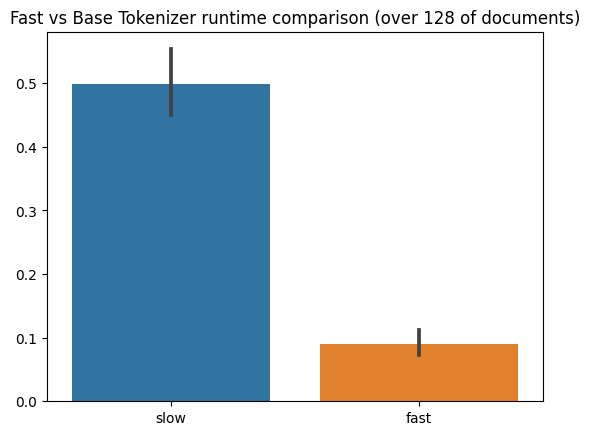

In [21]:
query = {"match_all": {}}
duration_slow = test_scroll(tokenize_slow, query)
duration_fast = test_scroll(tokenize_fast, query)

import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x = ["slow"] * len(duration_slow) + ["fast"] * len(duration_fast), y= duration_slow + duration_fast)
plt.title("Fast vs Base Tokenizer runtime comparison (over 128 of documents)")
plt.show()

Total documents found {'value': 211036967, 'relation': 'eq'}
[[48, 25, 198, 198, 4919, 284, 3975, 257, 9483, 287, 616, 16990, 284, 616, 1957], [34530, 18334, 198, 198, 34530, 18334, 11, 15226, 38454, 654, 11, 290, 15226, 8225, 743], [48, 25, 198, 198, 44, 15922, 18, 351, 33685, 360, 65, 11085, 11, 703, 284], [48, 25, 198, 198, 5159, 26789, 13326, 351, 309, 22854, 37535, 198, 198, 24661, 314], [4503, 32, 12889, 25, 3827, 81, 2530, 290, 3827, 25138, 198, 198, 29584, 13536, 6505], [41691, 23685, 25, 1881, 286, 262, 1266, 5935, 20433, 287, 3240, 290, 340, 447, 247], [35230, 312, 4104, 286, 262, 6110, 886, 418, 88, 2022, 295, 83, 1338, 7058, 489], [22342, 286, 13048, 198, 198, 22342, 286, 13048, 7499, 318, 257, 1853, 8200, 4065, 12], [2953, 718, 279, 13, 76, 13, 319, 257, 3909, 287, 2739, 2932, 11, 1862, 1466], [35, 292, 10680, 571, 937, 46358, 286, 19639, 317, 11, 49966, 11, 399, 30420, 17], [17353, 4771, 287, 262, 30967, 17565, 262, 8508, 287, 262, 30967, 30, 851, 10373, 11], [12814, 1061

[[2, 1288, 76, 12, 83, 24313, 12, 2118, 12, 15042, 198, 198, 0, 58, 51], [32, 10530, 8875, 4731, 318, 925, 286, 257, 4755, 286, 2587, 290, 42976, 36593, 286], [19156, 406, 13, 11264, 198, 198, 19156, 406, 13, 11264, 373, 257, 2888, 286, 262], [35, 15352, 869, 929, 257, 3236, 20309, 286, 262, 10854, 198, 198, 40, 1444, 616], [32, 311, 861, 11106, 12, 43, 2959, 12894, 2685, 22359, 290, 10241, 13, 21234, 11], [48, 25, 198, 198, 32071, 6889, 16624, 329, 26706, 4880, 351, 517, 621, 530, 269], [90, 198, 220, 366, 3672, 1298, 366, 21413, 12, 67, 34585, 1600, 198, 220, 366], [15580, 13645, 318, 257, 3788, 2478, 12948, 11812, 2891, 543, 3557, 689, 262, 17632, 14], [48, 25, 198, 198, 10331, 7427, 25, 618, 779, 20599, 3712, 19052, 11, 262, 7196], [56, 10949, 24075, 198, 198, 4264, 18856, 803, 290, 7205, 2402, 20351, 11501, 5419, 284], [47934, 10121, 198, 43401, 3712, 1136, 10786, 14, 27144, 11693, 3256, 705, 19209, 11693, 22130], [48, 25, 198, 198, 10445, 11693, 15957, 7343, 7515, 198, 198, 13921

[[76, 11370, 3742, 5860, 284, 30710, 362, 3715, 198, 198, 4863, 285, 11370, 3742, 319], [13681, 3834, 5945, 16065, 32238, 198, 198, 464, 220, 3878, 3834, 5945, 16065, 32238, 220], [48, 25, 198, 198, 4919, 318, 1262, 257, 27564, 2043, 13444, 1180, 422, 2391, 21207], [5377, 48074, 4410, 2555, 284, 1716, 517, 27888, 284, 4445, 1204, 13, 1119, 743, 1011], [43, 2821, 1601, 19770, 322, 35536, 11, 4280, 36478, 19770, 1666, 329, 347, 5379, 290], [27898, 10805, 7461, 18675, 198, 198, 1722, 383, 8599, 7832, 284, 7101, 514, 11, 4996], [48, 25, 198, 198, 46971, 84, 861, 338, 39290, 756, 259, 14834, 44728, 625, 262], [47934, 10121, 198, 35343, 198, 1635, 2488, 1073, 690, 19463, 9487, 3467, 37, 2238, 59], [42481, 198, 198, 13965, 6375, 2538, 15037, 851, 968, 12255, 13048, 3985, 11465, 49338, 460], [3886, 16693, 23240, 198, 198, 17543, 8702, 11, 2864, 532, 2080, 6186, 11, 3012, 11], [58, 1174, 37845, 1921, 12, 47, 3064, 2231, 1174, 60, 90, 32239, 198, 58, 1174], [15211, 198, 1635, 198, 1635, 15069, 3

[[3041, 73, 648, 3303, 198, 198, 3041, 73, 648, 357, 12093, 78, 449, 648, 11], [2437, 383, 5783, 7731, 770, 18321, 268, 383, 14219, 3226, 1584, 13661, 198, 198, 320], [7282, 287, 3862, 357, 14731, 7235, 16322, 647, 5062, 8, 198, 198, 7282, 287, 3862], [23672, 10026, 357, 501, 12217, 8, 198, 198, 23672, 1940, 5658, 10026, 357, 6286, 2795], [6329, 198, 397, 8709, 25, 705, 1026, 318, 880, 1900, 326, 281, 27468, 9629, 9639], [42, 9045, 265, 6065, 330, 4411, 16623, 198, 198, 42, 9045, 265, 6065, 330, 4411], [48, 25, 198, 198, 6090, 314, 2251, 14500, 281, 4554, 286, 281, 7231, 6060, 20885], [4061, 3060, 16746, 4903, 349, 5040, 19937, 198, 198, 10082, 349, 4374, 1096, 534, 4297], [5840, 5282, 347, 25337, 5169, 287, 968, 1971, 198, 198, 4023, 1378, 17474, 13, 19503], [198, 19214, 376, 13, 15979, 13, 17, 67, 642, 1507, 357, 16942, 8, 198, 32], [3103, 9641, 286, 290, 23341, 2945, 7935, 284, 18776, 290, 584, 290, 48686, 287, 915], [3132, 376, 13, 24041, 532, 198, 198, 3132, 376, 16, 67, 24041, 19

[[21159, 284, 3426, 14001, 49310, 329, 449, 2305, 9160, 198, 198, 2396, 2582, 290, 262], [48, 25, 198, 198, 1130, 29487, 17, 532, 21690, 14, 10374, 22086, 422, 20401, 29201], [1026, 318, 8027, 329, 2706, 284, 19361, 2985, 618, 257, 2524, 318, 1016, 284, 307], [23903, 319, 25, 1867, 561, 314, 19970, 21207, 30, 4023, 1378, 71, 8337, 2213, 5067], [48, 25, 198, 198, 19400, 20579, 1231, 6808, 1895, 30, 198, 198, 40, 1053, 4499], [48, 25, 198, 198, 39, 20369, 2443, 28659, 198, 198, 3666, 2443, 1595, 470, 10743], [2079, 16, 376, 13, 17, 67, 767, 4521, 198, 11929, 8476, 25, 3274, 13588, 10714], [464, 1944, 14250, 18436, 284, 281, 12064, 662, 13716, 1080, 329, 257, 1366, 7587, 4326], [44, 2470, 1535, 401, 273, 14065, 871, 290, 1575, 14, 22602, 1634, 10906, 287, 1182], [48, 25, 198, 198, 41, 17, 11682, 38492, 52, 2043, 2128, 2071, 319, 26182, 399], [48, 25, 198, 198, 3103, 1851, 16363, 45755, 6060, 284, 10903, 287, 327, 2, 198], [220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 1002, 

[[30150, 12489, 25, 9977, 1404, 3563, 11651, 318, 257, 4947, 286, 32209, 7392, 287, 13387], [1003, 198, 1003, 220, 24563, 13152, 9237, 6601, 29495, 13, 71, 198, 1003, 220, 8392], [24111, 36703, 25, 317, 3596, 284, 11436, 198, 198, 19844, 373, 257, 21140, 1110, 986], [48, 25, 198, 198, 33, 844, 1525, 25, 765, 284, 18941, 284, 3992, 6444, 19016], [14906, 2695, 198, 198, 12832, 49113, 5519, 24103, 511, 3160, 284, 2267, 11, 1690, 284], [40, 1276, 307, 1804, 1223, 8531, 13, 19826, 1740, 262, 8848, 1909, 11, 1234, 262], [17821, 1052, 22859, 12, 7738, 7235, 12440, 14701, 2896, 3628, 12, 259, 8894, 25743, 25], [464, 4384, 481, 2962, 319, 262, 3049, 5609, 995, 286, 319, 12, 28550, 5257, 15873], [48, 25, 198, 198, 4933, 38734, 281, 10006, 351, 281, 1081, 26621, 19482, 7383, 198], [464, 7585, 286, 5243, 8373, 357, 32754, 8, 2568, 284, 2496, 7652, 1626, 10712, 318], [48, 25, 198, 198, 15457, 278, 7885, 287, 1194, 1398, 5860, 9242, 198, 198, 18690], [18947, 4913, 198, 198, 12128, 1542, 3648, 198, 1

[[48, 25, 198, 198, 16979, 929, 26580, 284, 467, 717, 393, 1218, 198, 198, 40], [48, 25, 198, 198, 32901, 29978, 14307, 17230, 287, 24846, 7680, 198, 198, 40, 423], [21159, 1248, 11, 3050, 198, 198, 1, 41126, 603, 3216, 7831, 48463, 520, 733, 41676], [9980, 198, 198, 1925, 4565, 1359, 262, 8060, 38795, 9601, 198, 198, 940, 14, 2078], [48, 25, 198, 198, 2215, 389, 14, 611, 45115, 18413, 973, 30, 198, 198, 22229], [32961, 1340, 10468, 1377, 317, 4664, 10553, 46719, 4287, 5396, 1743, 468, 587, 11126, 13], [1, 464, 1109, 286, 262, 2300, 318, 339, 468, 407, 2077, 5798, 329, 883, 4028], [3886, 6035, 10916, 259, 198, 198, 2025, 7953, 3155, 2877, 287, 281, 7962, 319, 7542], [2025, 2736, 10045, 198, 198, 45, 620, 4587, 791, 353, 4679, 354, 2150, 748, 2629], [13217, 320, 48518, 6625, 290, 18955, 9695, 286, 3169, 747, 5142, 35140, 273, 17179, 2577], [198, 198, 5195, 836, 470, 356, 423, 25774, 12, 21466, 23767, 329, 8300, 30, 532], [32, 41432, 2050, 286, 262, 3048, 286, 262, 406, 20896, 499, 601, 

[[48, 25, 198, 198, 2437, 284, 2792, 4683, 953, 805, 13103, 284, 2153, 50217, 1628], [8248, 2634, 22710, 5439, 357, 51, 620, 709, 5665, 8, 198, 198, 8248, 2634, 22710], [18, 14, 1828, 14, 14315, 198, 198, 1532, 345, 1053, 407, 1775, 7324, 13, 353], [28821, 13281, 47957, 1078, 84, 198, 198, 28821, 13281, 47957, 1078, 84, 357, 18, 2932], [1858, 389, 517, 35478, 20954, 3917, 351, 428, 1097, 621, 2192, 597, 584, 314, 447], [4264, 395, 4444, 1903, 2233, 284, 35654, 25, 2561, 5453, 14591, 319, 3217, 0, 6930], [10814, 612, 290, 7926, 329, 428, 845, 2739, 10971, 13, 6930, 329, 345, 1611, 2456], [1003, 10097, 26866, 198, 1003, 1279, 22163, 4766, 2393, 2625, 38, 37020, 6690, 9255, 9237], [5956, 1227, 356, 4888, 366, 16962, 6897, 553, 262, 3452, 2060, 422, 262, 12902, 13212], [23, 4524, 376, 13, 17, 67, 767, 2624, 198, 19727, 317, 13, 509, 32, 1797], [464, 8737, 286, 3012, 15286, 318, 852, 1498, 284, 1630, 281, 5565, 3335, 1231, 1719], [48, 25, 198, 198, 6090, 314, 779, 30865, 27895, 9142, 20835,

[[38972, 8742, 338, 10156, 1625, 3812, 262, 886, 286, 257, 9604, 3249, 13, 930, 3486], [32, 1049, 640, 198, 198, 3666, 1545, 357, 8727, 468, 1239, 1333, 1496, 878, 8], [48, 25, 198, 198, 25512, 378, 3356, 287, 44161, 5752, 198, 198, 31373, 1312, 761], [2025, 16700, 286, 47767, 291, 12159, 12, 3846, 22448, 287, 1692, 2099, 362, 12593, 25], [48, 25, 198, 198, 2437, 284, 3440, 257, 2746, 422, 1194, 8265, 351, 6127, 32916], [23678, 40, 23099, 45954, 25732, 271, 290, 5658, 13333, 263, 301, 900, 572, 422, 511], [48, 25, 198, 198, 8491, 597, 286, 777, 19096, 12, 13049, 278, 6459, 23418, 30], [5211, 345, 766, 326, 12175, 12, 11534, 3335, 2029, 30, 1320, 338, 257, 32171, 1098], [2215, 314, 373, 257, 8150, 3915, 263, 11, 616, 2988, 561, 787, 257, 10273, 30784], [3103, 984, 723, 3164, 284, 262, 29526, 12123, 286, 262, 736, 1416, 1436, 290, 24774], [14933, 10223, 18714, 13798, 13, 6307, 18709, 278, 198, 90, 198, 220, 220, 220, 1171], [32, 33708, 6245, 4593, 318, 477, 900, 284, 711, 314, 8579, 1340

[[38, 4024, 11, 854, 34041, 1222, 49996, 17145, 1601, 15717, 198, 198, 14988, 1959, 2079], [10723, 278, 34067, 466, 1302, 12, 929, 318, 17774, 11, 8036, 11, 290, 257, 43671], [40, 39283, 319, 616, 289, 7335, 11, 3214, 284, 3668, 11, 290, 1138, 617, 29996], [26449, 13800, 318, 407, 3573, 7895, 11, 48676, 3660, 11, 393, 18700, 13, 632, 447], [220, 220, 220, 220, 220, 220, 10467, 5665, 3078, 286, 31876, 198, 220, 220, 220], [2, 17256, 1279, 4868, 29, 198, 2, 17256, 1279, 66, 19282, 952, 29, 198, 2], [48, 25, 198, 198, 2437, 284, 6105, 27179, 1758, 281, 7177, 286, 1588, 15225, 656], [805, 1312, 1101, 523, 1029, 826, 783, 1312, 460, 470, 772, 766, 616, 2951, 198], [1129, 2919, 764, 317, 804, 379, 281, 8389, 32676, 10086, 284, 4589, 17235, 7394, 416], [11980, 345, 1683, 3114, 379, 262, 10543, 447, 247, 82, 35664, 290, 1807, 284, 3511], [19703, 13967, 9030, 286, 9334, 70, 12664, 7059, 84, 418, 388, 7925, 287, 13622, 290], [25153, 2263, 257, 6253, 656, 534, 6628, 287, 257, 4436, 6334, 2119, 11

Total documents found {'value': 211036967, 'relation': 'eq'}
[[48, 25, 198, 198, 4919, 284, 3975, 257, 9483, 287, 616, 16990, 284, 616, 1957], [34530, 18334, 198, 198, 34530, 18334, 11, 15226, 38454, 654, 11, 290, 15226, 8225, 743], [48, 25, 198, 198, 44, 15922, 18, 351, 33685, 360, 65, 11085, 11, 703, 284], [48, 25, 198, 198, 5159, 26789, 13326, 351, 309, 22854, 37535, 198, 198, 24661, 314], [4503, 32, 12889, 25, 3827, 81, 2530, 290, 3827, 25138, 198, 198, 29584, 13536, 6505], [41691, 23685, 25, 1881, 286, 262, 1266, 5935, 20433, 287, 3240, 290, 340, 447, 247], [35230, 312, 4104, 286, 262, 6110, 886, 418, 88, 2022, 295, 83, 1338, 7058, 489], [22342, 286, 13048, 198, 198, 22342, 286, 13048, 7499, 318, 257, 1853, 8200, 4065, 12], [2953, 718, 279, 13, 76, 13, 319, 257, 3909, 287, 2739, 2932, 11, 1862, 1466], [35, 292, 10680, 571, 937, 46358, 286, 19639, 317, 11, 49966, 11, 399, 30420, 17], [17353, 4771, 287, 262, 30967, 17565, 262, 8508, 287, 262, 30967, 30, 851, 10373, 11], [12814, 1061

[[21906, 1391, 2, 82, 16, 92, 198, 25609, 198, 198, 32, 28004, 605, 387, 368], [198, 13464, 6069, 89, 13, 5125, 357, 42246, 8, 198, 31115, 350, 13, 17, 67], [12814, 383, 6705, 20021, 6530, 42500, 4809, 198, 198, 1532, 345, 389, 4508, 12, 3605], [6329, 198, 65, 45689, 25, 198, 12, 705, 23736, 59, 62, 27568, 13, 65, 571], [1532, 345, 2051, 6078, 3511, 329, 7982, 2431, 287, 257, 3223, 3807, 13766, 290, 423], [7222, 12, 12001, 1634, 286, 13759, 1173, 30788, 33549, 589, 16217, 382, 21797, 290, 49204], [25883, 287, 2677, 3418, 11, 2669, 11, 389, 4330, 625, 1771, 284, 28214, 720, 15259], [47123, 7036, 25241, 3414, 2961, 1909, 326, 340, 481, 711, 734, 12, 3847, 1182, 21310], [8777, 911, 3979, 198, 198, 8777, 911, 3979, 318, 281, 1605, 10997, 5581, 2168, 2727], [30120, 376, 13, 18, 67, 2310, 198, 19727, 317, 13, 360, 3955, 44, 22470, 11], [3673, 9723, 13, 198, 3673, 9723, 13, 198, 3673, 9723, 13, 198, 16, 13, 7663], [15924, 8326, 337, 729, 72, 198, 198, 15924, 8326, 337, 729, 72, 357, 6286, 303

[[18, 30, 198, 16, 198, 15979, 577, 532, 24, 9, 85, 532, 28598, 796, 532], [6329, 198, 397, 8709, 25, 930, 198, 220, 220, 220, 383, 13002, 1505, 20038, 329], [1, 42997, 11, 1770, 13, 12686, 526, 366, 42997, 11, 5502, 526, 366, 17250, 11], [2202, 262, 4656, 801, 81, 1146, 42550, 6948, 286, 262, 814, 41780, 25530, 286, 10645], [48017, 3984, 7208, 287, 38725, 364, 25, 644, 9853, 30, 35948, 286, 49615, 9633, 13], [27313, 198, 198, 464, 38433, 16941, 38786, 357, 23847, 8, 198, 198, 49771, 198, 1525], [22017, 11, 2198, 503, 428, 13779, 3288, 21541, 0, 337, 10757, 5437, 318, 257, 14081], [3109, 11578, 341, 355, 3513, 329, 10345, 22356, 291, 11916, 13, 198, 1858, 318, 10095], [27150, 11, 1315, 3267, 1946, 198, 198, 142, 231, 56, 11698, 12, 5673, 45484, 44441], [5990, 84, 379, 262, 39962, 2246, 8579, 3561, 5454, 198, 198, 1212, 318, 257, 1700], [198, 2937, 8141, 16, 29525, 628, 197, 628, 628, 198, 220, 220, 220, 220, 220], [7594, 867, 11336, 29715, 3296, 11, 2940, 4345, 359, 2125, 447, 247, 83,

[[21159, 284, 3426, 14001, 49310, 329, 449, 2305, 9160, 198, 198, 2396, 2582, 290, 262], [48, 25, 198, 198, 1130, 29487, 17, 532, 21690, 14, 10374, 22086, 422, 20401, 29201], [1026, 318, 8027, 329, 2706, 284, 19361, 2985, 618, 257, 2524, 318, 1016, 284, 307], [23903, 319, 25, 1867, 561, 314, 19970, 21207, 30, 4023, 1378, 71, 8337, 2213, 5067], [48, 25, 198, 198, 19400, 20579, 1231, 6808, 1895, 30, 198, 198, 40, 1053, 4499], [48, 25, 198, 198, 39, 20369, 2443, 28659, 198, 198, 3666, 2443, 1595, 470, 10743], [2079, 16, 376, 13, 17, 67, 767, 4521, 198, 11929, 8476, 25, 3274, 13588, 10714], [464, 1944, 14250, 18436, 284, 281, 12064, 662, 13716, 1080, 329, 257, 1366, 7587, 4326], [44, 2470, 1535, 401, 273, 14065, 871, 290, 1575, 14, 22602, 1634, 10906, 287, 1182], [48, 25, 198, 198, 41, 17, 11682, 38492, 52, 2043, 2128, 2071, 319, 26182, 399], [48, 25, 198, 198, 3103, 1851, 16363, 45755, 6060, 284, 10903, 287, 327, 2, 198], [220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 1002, 

[[30150, 12489, 25, 9977, 1404, 3563, 11651, 318, 257, 4947, 286, 32209, 7392, 287, 13387], [1003, 198, 1003, 220, 24563, 13152, 9237, 6601, 29495, 13, 71, 198, 1003, 220, 8392], [24111, 36703, 25, 317, 3596, 284, 11436, 198, 198, 19844, 373, 257, 21140, 1110, 986], [48, 25, 198, 198, 33, 844, 1525, 25, 765, 284, 18941, 284, 3992, 6444, 19016], [14906, 2695, 198, 198, 12832, 49113, 5519, 24103, 511, 3160, 284, 2267, 11, 1690, 284], [40, 1276, 307, 1804, 1223, 8531, 13, 19826, 1740, 262, 8848, 1909, 11, 1234, 262], [17821, 1052, 22859, 12, 7738, 7235, 12440, 14701, 2896, 3628, 12, 259, 8894, 25743, 25], [464, 4384, 481, 2962, 319, 262, 3049, 5609, 995, 286, 319, 12, 28550, 5257, 15873], [48, 25, 198, 198, 4933, 38734, 281, 10006, 351, 281, 1081, 26621, 19482, 7383, 198], [464, 7585, 286, 5243, 8373, 357, 32754, 8, 2568, 284, 2496, 7652, 1626, 10712, 318], [48, 25, 198, 198, 15457, 278, 7885, 287, 1194, 1398, 5860, 9242, 198, 198, 18690], [18947, 4913, 198, 198, 12128, 1542, 3648, 198, 1

[[48, 25, 198, 198, 16979, 929, 26580, 284, 467, 717, 393, 1218, 198, 198, 40], [48, 25, 198, 198, 32901, 29978, 14307, 17230, 287, 24846, 7680, 198, 198, 40, 423], [21159, 1248, 11, 3050, 198, 198, 1, 41126, 603, 3216, 7831, 48463, 520, 733, 41676], [9980, 198, 198, 1925, 4565, 1359, 262, 8060, 38795, 9601, 198, 198, 940, 14, 2078], [48, 25, 198, 198, 2215, 389, 14, 611, 45115, 18413, 973, 30, 198, 198, 22229], [32961, 1340, 10468, 1377, 317, 4664, 10553, 46719, 4287, 5396, 1743, 468, 587, 11126, 13], [1, 464, 1109, 286, 262, 2300, 318, 339, 468, 407, 2077, 5798, 329, 883, 4028], [3886, 6035, 10916, 259, 198, 198, 2025, 7953, 3155, 2877, 287, 281, 7962, 319, 7542], [2025, 2736, 10045, 198, 198, 45, 620, 4587, 791, 353, 4679, 354, 2150, 748, 2629], [13217, 320, 48518, 6625, 290, 18955, 9695, 286, 3169, 747, 5142, 35140, 273, 17179, 2577], [198, 198, 5195, 836, 470, 356, 423, 25774, 12, 21466, 23767, 329, 8300, 30, 532], [32, 41432, 2050, 286, 262, 3048, 286, 262, 406, 20896, 499, 601, 

[[48, 25, 198, 198, 2437, 284, 2792, 4683, 953, 805, 13103, 284, 2153, 50217, 1628], [8248, 2634, 22710, 5439, 357, 51, 620, 709, 5665, 8, 198, 198, 8248, 2634, 22710], [18, 14, 1828, 14, 14315, 198, 198, 1532, 345, 1053, 407, 1775, 7324, 13, 353], [28821, 13281, 47957, 1078, 84, 198, 198, 28821, 13281, 47957, 1078, 84, 357, 18, 2932], [1858, 389, 517, 35478, 20954, 3917, 351, 428, 1097, 621, 2192, 597, 584, 314, 447], [4264, 395, 4444, 1903, 2233, 284, 35654, 25, 2561, 5453, 14591, 319, 3217, 0, 6930], [10814, 612, 290, 7926, 329, 428, 845, 2739, 10971, 13, 6930, 329, 345, 1611, 2456], [1003, 10097, 26866, 198, 1003, 1279, 22163, 4766, 2393, 2625, 38, 37020, 6690, 9255, 9237], [5956, 1227, 356, 4888, 366, 16962, 6897, 553, 262, 3452, 2060, 422, 262, 12902, 13212], [23, 4524, 376, 13, 17, 67, 767, 2624, 198, 19727, 317, 13, 509, 32, 1797], [464, 8737, 286, 3012, 15286, 318, 852, 1498, 284, 1630, 281, 5565, 3335, 1231, 1719], [48, 25, 198, 198, 6090, 314, 779, 30865, 27895, 9142, 20835,

[[13217, 282, 2441, 263, 198, 198, 13217, 282, 2441, 263, 357, 6286, 838, 3267, 21577], [16616, 376, 13, 18, 67, 1105, 3559, 198, 11929, 8476, 25, 32547, 13588, 14330, 4570], [12473, 23852, 2751, 11, 36388, 447, 247, 50, 4526, 5105, 32936, 3963, 5870, 28893, 784], [40, 10395, 412, 12473, 18, 20233, 379, 838, 321, 319, 3217, 13, 198, 198, 9690], [48, 25, 198, 198, 2437, 284, 20292, 331, 16488, 7110, 2837, 287, 6550, 23912, 30], [47, 17407, 278, 32070, 313, 44086, 1262, 309, 1140, 19248, 287, 30590, 13401, 21797, 290], [2061, 389, 262, 9695, 286, 1353, 16937, 10856, 30, 1148, 612, 257, 10451, 329, 511], [50, 353, 1868, 1006, 974, 652, 6175, 2685, 30675, 11815, 351, 24537, 30362, 24427, 37646], [464, 14250, 18436, 284, 257, 1021, 12, 10217, 1176, 2891, 11, 287, 1948, 257, 1176], [48, 25, 198, 198, 2061, 857, 366, 7784, 1, 1612, 994, 30, 198, 198, 464], [35013, 286, 1204, 8922, 878, 290, 706, 1007, 495, 400, 1373, 1599, 596, 286, 262], [12966, 35738, 5182, 287, 3585, 2526, 286, 1218, 4165,

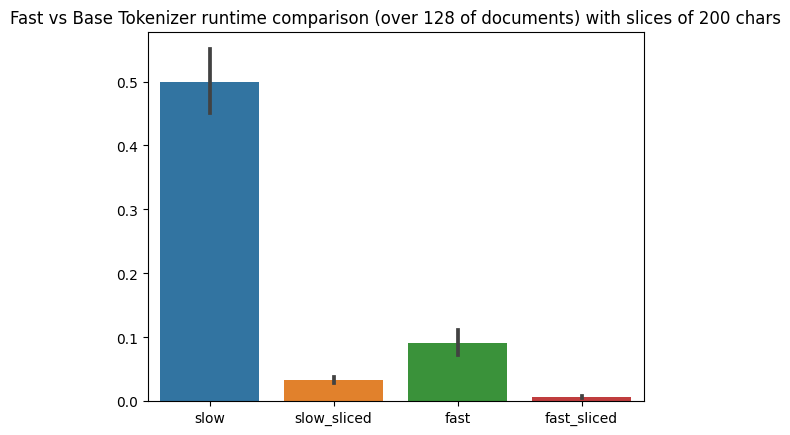

In [60]:
import time as t
import es_utils

def filter_tokens(tokens, tokens_mask):
    """Filter tokens based on the mask"""
    return [token for token, mask in zip(tokens, tokens_mask) if mask]

def filter_tokenizer_results(results: dict):
    """Filter tokens based on the masks."""
    batch_tokens = []

    for tokens, tokens_mask in zip(results["input_ids"], results["attention_mask"]):
        valid_tokens = [token for token, mask in zip(tokens, tokens_mask) if mask]
        batch_tokens.append(valid_tokens)

    return batch_tokens

def test_sliced_scroll(tokenize: callable, query: dict, total_iters=20):
    duration = []
    num_tokens = []
    data = iter(es_utils.scroll(es, query, size=128, scroll="10m", index="re_pile"))

    for i in range(total_iters):
        try:
            docs = next(data)
        except:
            pass
        
        start = t.time()
        results = tokenize([es_utils.get_text(d)[:200] for d in docs])
        duration.append(t.time() - start)
        
        #print(filter_tokenizer_results(results))
        
        j = 0
        for (inp, mask) in zip(results["input_ids"], results["attention_mask"]):
            tokens = filter_tokens(inp, mask)
            num_tokens.append(len(tokens))
            
            if num_tokens[-1] < 15:
                print(docs[j])
                print(tokens)
                
            j += 1
        
    return duration, num_tokens


query = {"match_all": {}}
duration_sliced_slow, num_tokens_slow = test_sliced_scroll(tokenize_slow, query)
print()
duration_sliced_fast, num_tokens_fast = test_sliced_scroll(tokenize_fast, query)

import seaborn as sns
import matplotlib.pyplot as plt
x = (
    ["slow"] * len(duration_slow) 
    + ["slow_sliced"] * len(duration_sliced_slow)
    + ["fast"] * len(duration_fast)
    + ["fast_sliced"] * len(duration_sliced_fast)
)
y = duration_slow + duration_sliced_slow + duration_fast + duration_sliced_fast
sns.barplot(x=x, y=y)
plt.title("Fast vs Base Tokenizer runtime comparison (over 128 of documents) with slices of 200 chars")
plt.show()

In [51]:
tokenizer_fast.decode([15, 197, 16, 198, 16, 197, 19, 198, 18, 197, 21, 198])


'0\t1\n1\t4\n3\t6\n'

In [58]:
from collections import Counter 

Counter(num_tokens_slow).most_common()

[(15, 2555), (14, 2), (12, 1), (11, 1), (9, 1)]

In [59]:
Counter(num_tokens_fast).most_common()

[(15, 2555), (14, 2), (12, 1), (11, 1), (9, 1)]